# Initialize

In [1]:
from ops.imports_ipython import *
import glob

In [ ]:
os.chdir('20200202_6W-LaC024D/')

# combine tables

In [4]:
ops.utils.combine_tables('cp_phenotype',output_filetype='hdf',subdir='process_ph/tables',n_jobs=-2,
    usecols=[
        'well','tile','cell',
        'i','j','bounds_0','bounds_1','bounds_2','bounds_3',
        # to identify cells on an acquisition border
        'cell_dapi_min','cell_tubulin_min','cell_gh2ax_min','cell_phalloidin_min'
        ]
)
os.rename('cp_phenotype.hdf','min_cp_phenotype.hdf')

In [5]:
ops.utils.combine_tables('merge',output_filetype='hdf',subdir='alignment',n_jobs=-2)

In [ ]:
ops.utils.combine_tables('cells',output_filetype='hdf',subdir='process_sbs/tables',n_jobs=-2)

In [7]:
df_merged = pd.read_hdf('merge.hdf')

# add distance to FOV center for each cell

In [8]:
def fov_distance(df,i='i',j='j',dimensions=(2960,2960),suffix=''):
    distance  = lambda x: np.sqrt((x[i]-(dimensions[0]/2))**2+(x[j]-(dimensions[1]/2))**2)
    df['fov_distance'+suffix]=df.apply(distance,axis=1)
    return df

In [9]:
df_merged.pipe(fov_distance,i='i_0',j='j_0',suffix='_0');

In [10]:
df_merged.pipe(fov_distance,i='i_1',j='j_1',dimensions=(1480,1480),suffix='_1');

In [11]:
df_merged.sort_values(['fov_distance_1']).head()

,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,distance,fov_distance_0,fov_distance_1
627,B3,732,667,1519.187224,1433.869287,182,2596,740.111111,739.748148,0.182339,60.528350,0.275273
951,A1,974,984,1528.290573,1425.692124,256,3337,740.166667,740.313725,0.337688,72.672724,0.355248
451,A1,326,471,1493.697223,1462.105333,86,1975,740.409722,739.854167,0.099953,22.535151,0.434902
562,A1,646,595,1510.808555,1450.379383,169,2199,740.436782,740.068966,0.285142,42.738133,0.442193
432,B2,728,448,1513.234426,1445.959836,184,1786,739.782051,740.410256,0.087432,47.573731,0.464556


# add mapping info

In [12]:
df_cells = pd.read_hdf('cells.hdf')

In [14]:
df_cells.head()

,cell,tile,well,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,...,cell_barcode_count_0,cell_barcode_1,cell_barcode_count_1,barcode_count,sgRNA_0,gene_symbol_0,group_0,sgRNA_1,gene_symbol_1,group_1
0,25,197,B3,1.000000,0.579873,0.357532,0.509846,0.179050,0.602376,0.093189,...,1,TGTTAAGAAAG,1.0,2,NaN,NaN,NaN,NaN,NaN,NaN
1,33,197,B3,0.219040,0.656760,0.428641,0.572109,0.670091,0.226627,0.622669,...,1,NaN,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN
2,34,197,B3,0.899700,0.780513,1.000000,0.688264,0.791304,0.769204,0.721780,...,1,NaN,0.0,1,GCCCCACGTCGGGCGAGGTG,JUN,essentials_11L2,NaN,NaN,NaN
3,35,197,B3,0.646601,0.422292,0.316002,0.522432,0.382589,0.972196,0.265143,...,3,NaN,0.0,3,GGAGTGAGTTACCTTCCATG,OS9,essentials_11L2,NaN,NaN,NaN
4,38,197,B3,0.581712,0.470132,0.352224,1.000000,0.419610,0.911610,0.216308,...,2,GCAGTACAGGA,1.0,4,GGAGTGAGTTACCTTCCATG,OS9,essentials_11L2,NaN,NaN,NaN


In [13]:
df_cells['mapped_single_gene'] = (df_cells.apply(lambda x: True 
                    if (pd.notnull(x.gene_symbol_0)&pd.isnull(x.gene_symbol_1))|(x.gene_symbol_0==x.gene_symbol_1) 
                    else False,axis=1)
                                  )

In [14]:
df_cells.mapped_single_gene.value_counts()

True     4672031
False    1948041
Name: mapped_single_gene, dtype: int64

In [15]:
df_merged = df_merged.merge((df_cells[['well','tile','cell','sgRNA_0','gene_symbol_0','group_0','mapped_single_gene']]
                             .rename({'tile':'site','cell':'cell_1'},axis=1)),
                            how='left',on=['well','site','cell_1'])

In [19]:
df_merged.head(10).sort_values(['mapped_single_gene','fov_distance_1'],ascending=[False,True])

,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,distance,fov_distance_0,fov_distance_1,sgRNA_0,gene_symbol_0,group_0,mapped_single_gene
4,B1,1122,16,59.317957,1650.814388,296,1107,376.369369,154.090090,0.870972,1430.914051,689.577884,GACCAACGTAGTATTTGCTG,TCOF1,essentials_11L2,True
6,B1,1122,22,79.150420,1590.083280,296,1121,381.109890,139.153846,0.486947,1405.168273,699.870139,GACCAACGTAGTATTTGCTG,TCOF1,essentials_11L2,True
3,B1,1122,14,52.045532,1516.853159,296,1097,374.095652,120.200000,1.022004,1428.429948,719.748589,GACCAACGTAGTATTTGCTG,TCOF1,essentials_11L2,True
9,B1,1122,26,109.025654,1479.035079,296,1140,388.024793,111.132231,0.790635,1370.974685,720.667202,GACCAACGTAGTATTTGCTG,TCOF1,essentials_11L2,True
8,B1,1122,23,81.182078,2758.833174,296,1127,382.629630,432.861111,1.488484,1895.285168,471.219565,NaN,NaN,NaN,False
1,B1,1122,9,30.609504,2820.042700,296,1081,369.175258,449.175258,0.361054,1973.942058,471.264279,NaN,NaN,NaN,False
2,B1,1122,10,35.934426,2317.230802,296,1089,371.047297,321.594595,1.362257,1669.215624,557.843329,NaN,NaN,NaN,False
0,B1,1122,8,29.521155,2252.254853,296,1080,369.555556,305.244444,1.428717,1643.248745,571.175524,NaN,NaN,NaN,False
5,B1,1122,17,64.029373,2189.173170,296,1111,378.396825,289.412698,1.537713,1583.634870,577.741960,NaN,NaN,NaN,False
7,B1,1122,20,73.697384,2572.263377,296,1122,381.157303,386.101124,1.702067,1780.653344,503.996523,NaN,NaN,NaN,NaN


# add phenotype min info

In [16]:
df_phenotype = pd.read_hdf('min_cp_phenotype.hdf').fillna(0)

In [17]:
min_cols = [col for col in df_phenotype.columns if '_min' in col]
info_cols = [col for col in df_phenotype.columns if col not in min_cols]

In [19]:
df_phenotype['channels_min'] = df_phenotype[min_cols].apply(lambda x: x.min(axis=0),axis=1)

In [21]:
df_merged = df_merged.merge((df_phenotype[['well','tile','cell','channels_min']]
                             .rename(columns={'cell':'cell_0'})),
                            how='left',on=['well','tile','cell_0'])

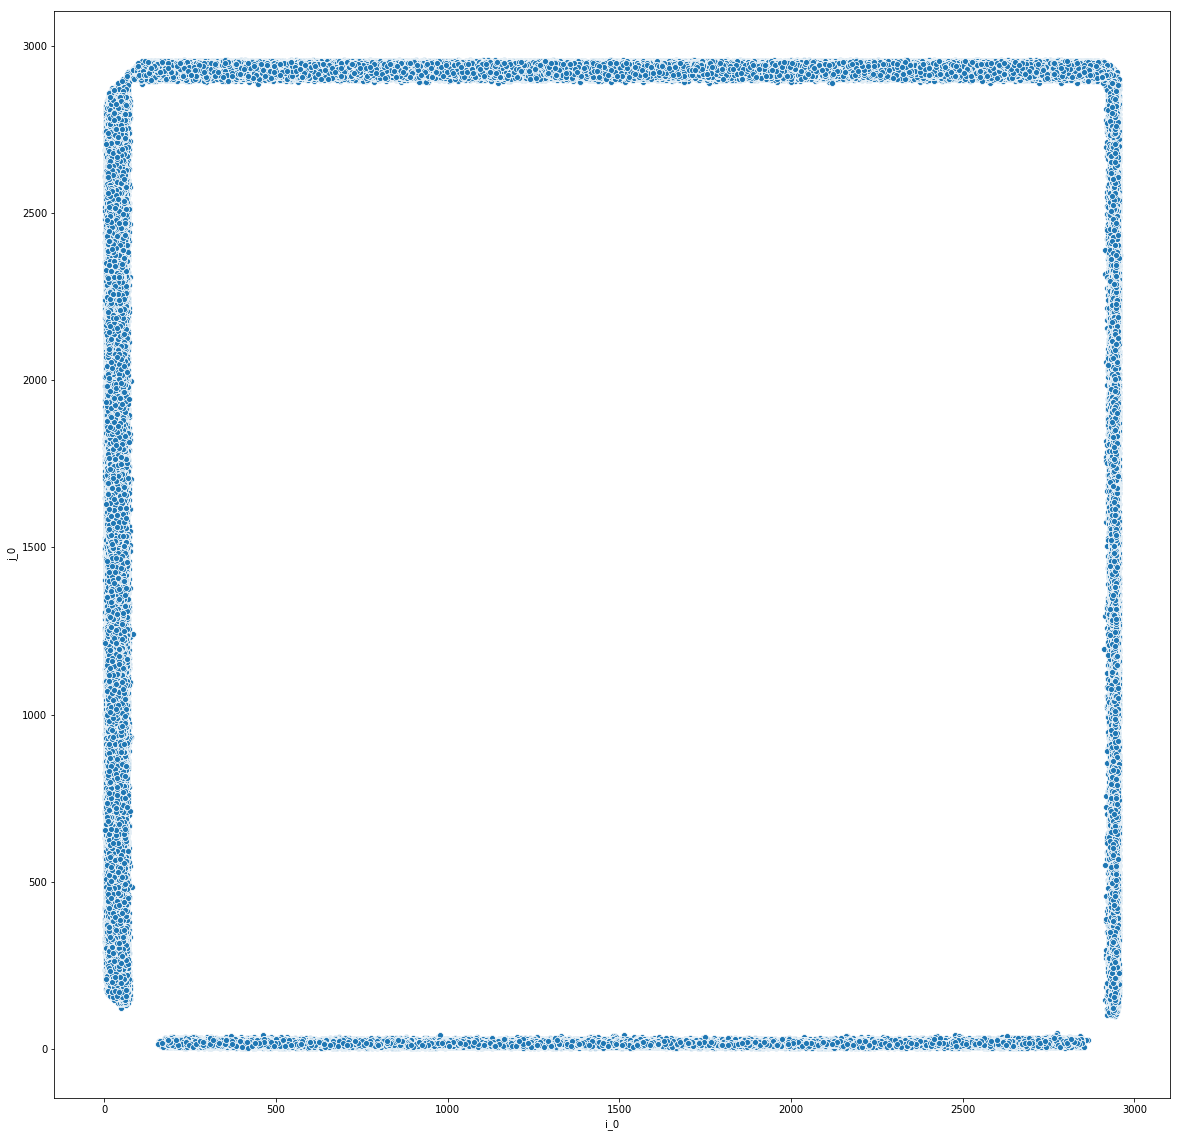

In [22]:
# visualize cells overlapping channel alignment edges
# (only relevant if phenotype channels are acquired separately)
plt.figure(figsize=(20,20))
sns.scatterplot(data=(df_merged
                      .query('channels_min==0')
                      [['i_0','j_0']]
                     ),
                x='i_0',y='j_0')

# filter merged datasets for duplicates

In [6]:
df_merged.groupby(['well','tile']).cell_0.value_counts().value_counts()

1    6115244
2    1721496
3      33149
4       1907
Name: cell_0, dtype: int64

In [7]:
df_merged.groupby(['well','site']).cell_1.value_counts().value_counts()

1    5747083
2    1769707
3      73646
4      39469
Name: cell_1, dtype: int64

In [8]:
df_merged.drop_duplicates(['well','site','cell_1']).pipe(len)

7629905

In [9]:
df_merged.pipe(len)

9665311

In [10]:
# remove cells with phenotype channel min ==0
df_merged_ph = (df_merged
             .query('channels_min>0')
            )

In [11]:
df_merged_ph.drop_duplicates(['well','site','cell_1']).pipe(len)

7605454

In [12]:
df_merged_ph.groupby(['well','site']).cell_1.value_counts().value_counts()

1    6046526
2    1484426
3      48211
4      26291
Name: cell_1, dtype: int64

In [13]:
# drop sbs cells mapping to same phenotype cell by priority (mapping, fov_distance)
df_merged_filt = (df_merged_ph
                  .sort_values(['mapped_single_gene','fov_distance_1'],
                               ascending=[False,True])
                  .drop_duplicates(['well','tile','cell_0'],keep='first')
                 )

In [14]:
df_merged_filt.groupby(['well','site']).cell_1.value_counts().value_counts()

1    4695372
2    1282719
3      48211
4      26291
Name: cell_1, dtype: int64

In [15]:
# drop duplicated phenotype cells mapping to same sbs cell by priority (fov_distance)
df_merged_filt_filt = (df_merged_filt
                       .sort_values(['fov_distance_0'],ascending=True)
                       .drop_duplicates(['well','site','cell_1'],keep='first')
                      )

In [16]:
df_merged_filt_filt.pipe(len)

6052593

In [17]:
df_merged_filt_filt[df_merged_filt_filt.mapped_single_gene==True].pipe(len)

3582263

In [ ]:
df_merged.to_hdf('merge.hdf', 'x', mode='w')

In [ ]:
df_merged_filt_filt.to_hdf('merged_deduped.hdf', 'x', mode='w')

# check cell matching rate

In [ ]:
df_merged_filt_filt.well.value_counts()

B2    1321519
A2    1305725
B1    1156112
A1    1152767
B3    1116470
Name: well, dtype: int64

In [23]:
df_sbs_info = pd.concat([pd.read_hdf(f) for f in glob.glob('sbs_info_*.hdf')])

In [24]:
df_sbs_info.to_hdf('sbs_info.hdf','x',mode='w')

In [25]:
# cols_0 = {'i':'i_0','j':'j_0','cell':'cell_0','tile':'tile_0'}
cols_1 = {'cell':'cell_1','tile':'site'}

#before deduping, how many sbs cells map to a phenotype cell
df_sbs_matching = (df_sbs_info
                   .rename(columns=cols_1)
                   .drop(columns=['i','j'])
                   .merge(df_merged,
#                         .rename(columns=cols_0),
                        how='left',on=['well','site','cell_1'])
                  )

In [26]:
for well,df in df_sbs_matching.groupby('well'):
    all_cells = df.pipe(len)
    lonely_cells = df.distance.isnull().sum()
    mapping = (all_cells-lonely_cells)/all_cells
    print('For well '+well+', cell matching rate is '+str(mapping*100)+'%')

For well A1, cell matching rate is 90.39955178939577%
For well A2, cell matching rate is 89.94942923818154%
For well B1, cell matching rate is 90.39353107598893%
For well B2, cell matching rate is 89.34156496084381%
For well B3, cell matching rate is 90.09092547321578%


In [28]:
del df_sbs_matching

In [29]:
del df_sbs_info

In [30]:
df_ph_info = pd.concat([pd.read_hdf(f) for f in glob.glob('ph_info_*.hdf')])

In [31]:
df_ph_info.to_hdf('ph_info.hdf','x',mode='w')

In [32]:
# cols_0 = {'i':'i_0','j':'j_0','cell':'cell_0','tile':'tile_0'}
cols_1 = {'cell':'cell_0'}

#before deduping, how many sbs cells map to a phenotype cell
df_ph_matching = (df_ph_info
                 .rename(columns=cols_1)
                 .drop(columns=['i','j'])
                 .merge(df_merged,
#                         .rename(columns=cols_0),
                        how='left',on=['well','tile','cell_0'])
                )

In [33]:
for well,df in df_ph_matching.groupby('well'):
    all_cells = df.pipe(len)
    lonely_cells = df.distance.isnull().sum()
    mapping = (all_cells-lonely_cells)/all_cells
    print('For well '+well+', cell matching rate is '+str(mapping*100)+'%')

For well A1, cell matching rate is 93.948239105296%
For well A2, cell matching rate is 93.70942386170226%
For well B1, cell matching rate is 94.09556849835401%
For well B2, cell matching rate is 93.56290972277071%
For well B3, cell matching rate is 93.41732743410078%
